In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 28.1 MB/s eta 0:00:00


This code was written with this : https://github.com/neuralsorcerer/variational-quantum-classifier/blob/main/main.ipynb

However later, we introduce imbalance in the code, to try to emulate what would happen for a fraud and real transaction, or the loan dataset

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

The labels are converted to {-1, +1} because the quantum models output (an expectation value of a Pauli-Z measurement) naturally ranges from -1 to + 1

In [ ]:
# Generate a 2D classification dataset
X, y = make_classification(n_samples=100, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1, random_state=42)

# Normalize features
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels from {0, 1} to {-1, +1}
y_train = 2*y_train - 1
y_test = 2*y_test - 1

In [ ]:
n_qubits = 2
#2-qubit 2-qubit quantum simulator (default.qubit device) from PennyLane.
#Each input vector will be encoded into the states of these two qubits
dev = qml.device("default.qubit", wires=n_qubits)

In [ ]:
#Using angle encoding

def feature_encoding(x):
    # Encode each feature into a qubit's rotation angle.
    # Here we use AngleEmbedding from PennyLane
    qml.AngleEmbedding(x, wires=range(n_qubits), rotation='Y')

def variational_circuit(params, x):
    # Encode features into qubits
    feature_encoding(x)

    # params shape: (num_layers, n_qubits, 3)
    # Each qubit in each layer has 3 parameters for RX, RY, and RZ rotations
    for layer_params in params:
        for i, wire_params in enumerate(layer_params):
            qml.RX(wire_params[0], wires=i)
            qml.RY(wire_params[1], wires=i)
            qml.RZ(wire_params[2], wires=i)

        # Entangle the qubits with CNOT gates
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i+1])

    # Measure expectation value of Pauli-Z on the first qubit
    return qml.expval(qml.PauliZ(0))

In [ ]:
@qml.qnode(dev, interface='autograd')
def quantum_model(params, x):
    return variational_circuit(params, x)

def loss(params, X, Y):
    predictions = [quantum_model(params, x) for x in X]
    predictions = np.stack(predictions)
    # Mean Squared Error: (fθ(x) - y)^2 averaged over the dataset
    return np.mean((predictions - Y)**2)

def accuracy(params, X, Y):
    predictions = [quantum_model(params, x) for x in X]
    predictions = np.sign(np.stack(predictions))
    return np.mean(predictions == Y)


In [ ]:
num_layers = 2
params = 0.01 * np.random.randn(num_layers, n_qubits, 3)

#Optimization
We use a simple gradient descent optimizer with a 0.1 learning rate.
We will train for 50 epochs, recording metrics each time.

What does Epochs mean ?

An epoch is one complete pass through the entire training dataset during optimization of the parameters.


We also experiment with different optimizers to see if that has any effect on the task, because I have seen in the past atleast for QAOA that they do depend on the nature of optimizer being used.

Notably in PennyLane, gradients are computed by using the parameter-shift rule to compute derivatives of expectation values.

In [ ]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)
num_epochs = 50

epoch_list = []
loss_list = []
train_acc_list = []
test_acc_list = []

In [ ]:
for epoch in range(num_epochs):
    # Update parameters by taking a gradient step on the loss w.r.t. params
    params = opt.step(lambda v: loss(v, X_train, y_train), params)
    current_loss = loss(params, X_train, y_train)
    train_acc = accuracy(params, X_train, y_train)
    test_acc = accuracy(params, X_test, y_test)

    epoch_list.append(epoch+1)
    loss_list.append(current_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: Loss = {current_loss:.4f}, "
          f"Train Acc = {train_acc:.2f}, Test Acc = {test_acc:.2f}")

Epoch 1/50: Loss = 1.8830, Train Acc = 0.42, Test Acc = 0.30
Epoch 2/50: Loss = 1.8725, Train Acc = 0.42, Test Acc = 0.30
Epoch 3/50: Loss = 1.8590, Train Acc = 0.44, Test Acc = 0.30
Epoch 4/50: Loss = 1.8414, Train Acc = 0.44, Test Acc = 0.30
Epoch 5/50: Loss = 1.8181, Train Acc = 0.45, Test Acc = 0.30
Epoch 6/50: Loss = 1.7878, Train Acc = 0.45, Test Acc = 0.30
Epoch 7/50: Loss = 1.7485, Train Acc = 0.45, Test Acc = 0.30
Epoch 8/50: Loss = 1.6989, Train Acc = 0.44, Test Acc = 0.30
Epoch 9/50: Loss = 1.6379, Train Acc = 0.44, Test Acc = 0.30
Epoch 10/50: Loss = 1.5658, Train Acc = 0.42, Test Acc = 0.30
Epoch 11/50: Loss = 1.4842, Train Acc = 0.42, Test Acc = 0.35
Epoch 12/50: Loss = 1.3960, Train Acc = 0.46, Test Acc = 0.35
Epoch 13/50: Loss = 1.3053, Train Acc = 0.50, Test Acc = 0.40
Epoch 14/50: Loss = 1.2159, Train Acc = 0.53, Test Acc = 0.45
Epoch 15/50: Loss = 1.1312, Train Acc = 0.55, Test Acc = 0.50
Epoch 16/50: Loss = 1.0532, Train Acc = 0.56, Test Acc = 0.60
Epoch 17/50: Loss

In [ ]:
final_train_acc = accuracy(params, X_train, y_train)
final_test_acc = accuracy(params, X_test, y_test)
print(f"Final Training Accuracy: {final_train_acc:.2f}")
print(f"Final Test Accuracy: {final_test_acc:.2f}")

Final Training Accuracy: 0.89
Final Test Accuracy: 1.00


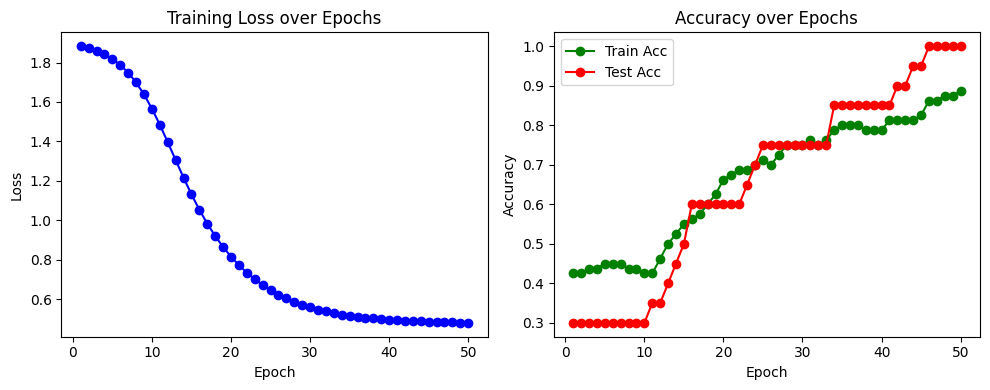

In [ ]:
plt.figure(figsize=(10,4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epoch_list, loss_list, marker='o', color='blue')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epoch_list, train_acc_list, marker='o', label="Train Acc", color='green')
plt.plot(epoch_list, test_acc_list, marker='o', label="Test Acc", color='red')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

**Now we do the same for the imbalanced dataset**

In [ ]:
from collections import Counter
# 2. Generate small synthetic imbalanced dataset
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2, n_redundant=0, weights=[0.95, 0.05], random_state=42)
# Count occurrences of each class
counter = Counter(y)
print("Class distribution:", counter)

Class distribution: Counter({np.int64(0): 4722, np.int64(1): 278})


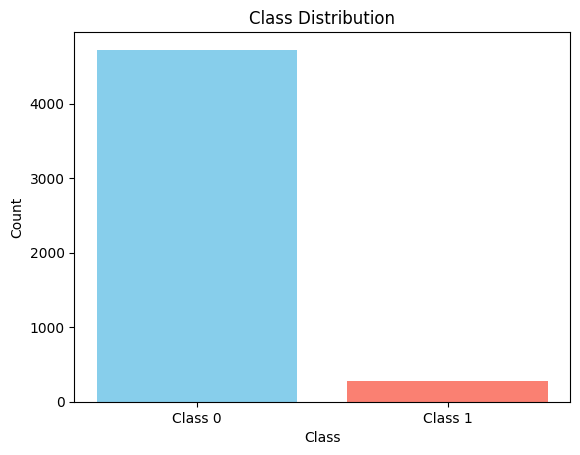

In [ ]:
classes = np.unique(y)
counts = [np.sum(y == c) for c in classes]

plt.bar(classes, counts, tick_label=["Class 0", "Class 1"], color=["skyblue", "salmon"])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
#plt.grid(True, axis='y')
plt.show()

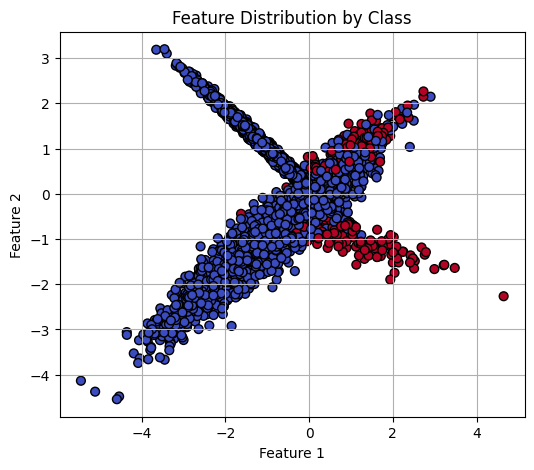

In [ ]:
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolors='k', s=40)
plt.title("Feature Distribution by Class")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()


In [ ]:
# 2. Generate small synthetic imbalanced dataset
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, weights=[0.80, 0.20], random_state=42)
# Normalize features
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels from {0, 1} to {-1, +1}
y_train = 2*y_train - 1
y_test = 2*y_test - 1

In [ ]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

In [ ]:
#Using angle encoding

def feature_encoding(x):
    # Encode each feature into a qubit's rotation angle.
    # Here we use AngleEmbedding from PennyLane
    qml.AngleEmbedding(x, wires=range(n_qubits), rotation='Y')

def variational_circuit(params, x):
    # Encode features into qubits
    feature_encoding(x)

    # params shape: (num_layers, n_qubits, 3)
    # Each qubit in each layer has 3 parameters for RX, RY, and RZ rotations
    for layer_params in params:
        for i, wire_params in enumerate(layer_params):
            qml.RX(wire_params[0], wires=i)
            qml.RY(wire_params[1], wires=i)
            qml.RZ(wire_params[2], wires=i)

        # Entangle the qubits with CNOT gates
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i+1])

    # Measure expectation value of Pauli-Z on the first qubit
    return qml.expval(qml.PauliZ(0))

In [ ]:
@qml.qnode(dev, interface='autograd')
def quantum_model(params, x):
    return variational_circuit(params, x)

def loss(params, X, Y):
    predictions = [quantum_model(params, x) for x in X]
    predictions = np.stack(predictions)
    # Mean Squared Error: (fθ(x) - y)^2 averaged over the dataset
    return np.mean((predictions - Y)**2)

def accuracy(params, X, Y):
    predictions = [quantum_model(params, x) for x in X]
    predictions = np.sign(np.stack(predictions))
    return np.mean(predictions == Y)

In [ ]:
num_layers = 2
params = 0.01 * np.random.randn(num_layers, n_qubits, 3)

In [ ]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)
num_epochs = 50

epoch_list = []
loss_list = []
train_acc_list = []
test_acc_list = []

In [ ]:
for epoch in range(num_epochs):
    # Update parameters by taking a gradient step on the loss w.r.t. params
    params = opt.step(lambda v: loss(v, X_train, y_train), params)
    current_loss = loss(params, X_train, y_train)
    train_acc = accuracy(params, X_train, y_train)
    test_acc = accuracy(params, X_test, y_test)

    epoch_list.append(epoch+1)
    loss_list.append(current_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: Loss = {current_loss:.4f}, "
          f"Train Acc = {train_acc:.2f}, Test Acc = {test_acc:.2f}")

Epoch 1/50: Loss = 2.5673, Train Acc = 0.19, Test Acc = 0.21
Epoch 2/50: Loss = 2.4570, Train Acc = 0.21, Test Acc = 0.23
Epoch 3/50: Loss = 2.3226, Train Acc = 0.24, Test Acc = 0.23
Epoch 4/50: Loss = 2.1664, Train Acc = 0.28, Test Acc = 0.23
Epoch 5/50: Loss = 1.9940, Train Acc = 0.30, Test Acc = 0.24
Epoch 6/50: Loss = 1.8134, Train Acc = 0.38, Test Acc = 0.29
Epoch 7/50: Loss = 1.6333, Train Acc = 0.44, Test Acc = 0.37
Epoch 8/50: Loss = 1.4613, Train Acc = 0.47, Test Acc = 0.41
Epoch 9/50: Loss = 1.3026, Train Acc = 0.52, Test Acc = 0.49
Epoch 10/50: Loss = 1.1601, Train Acc = 0.58, Test Acc = 0.54
Epoch 11/50: Loss = 1.0348, Train Acc = 0.61, Test Acc = 0.58
Epoch 12/50: Loss = 0.9262, Train Acc = 0.66, Test Acc = 0.62
Epoch 13/50: Loss = 0.8332, Train Acc = 0.71, Test Acc = 0.63
Epoch 14/50: Loss = 0.7541, Train Acc = 0.74, Test Acc = 0.67
Epoch 15/50: Loss = 0.6873, Train Acc = 0.76, Test Acc = 0.67
Epoch 16/50: Loss = 0.6310, Train Acc = 0.78, Test Acc = 0.73
Epoch 17/50: Loss

In [ ]:
final_train_acc = accuracy(params, X_train, y_train)
final_test_acc = accuracy(params, X_test, y_test)
print(f"Final Training Accuracy: {final_train_acc:.2f}")
print(f"Final Test Accuracy: {final_test_acc:.2f}")

Final Training Accuracy: 0.89
Final Test Accuracy: 0.87


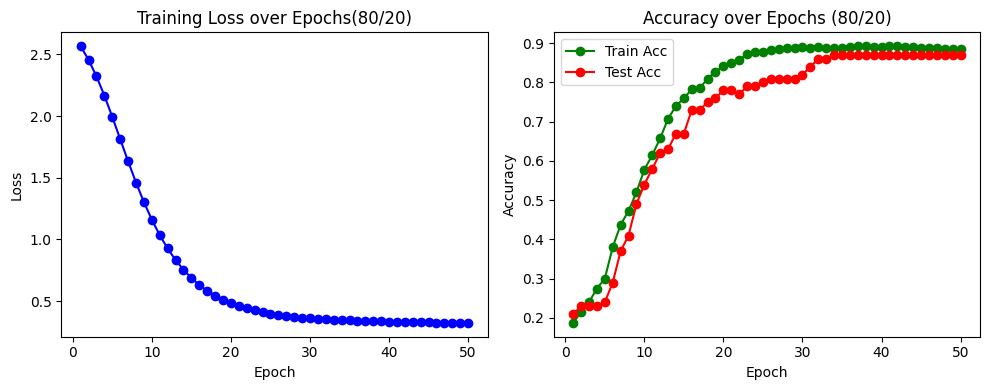

In [ ]:
plt.figure(figsize=(10,4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epoch_list, loss_list, marker='o', color='blue')
plt.title("Training Loss over Epochs(80/20)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epoch_list, train_acc_list, marker='o', label="Train Acc", color='green')
plt.plot(epoch_list, test_acc_list, marker='o', label="Test Acc", color='red')
plt.title("Accuracy over Epochs (80/20)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 2. Generate small synthetic imbalanced dataset
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, weights=[0.95, 0.05], random_state=42)
# Normalize features
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels from {0, 1} to {-1, +1}
y_train = 2*y_train - 1
y_test = 2*y_test - 1

In [ ]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

#Using angle encoding

def feature_encoding(x):
    # Encode each feature into a qubit's rotation angle.
    # Here we use AngleEmbedding from PennyLane
    qml.AngleEmbedding(x, wires=range(n_qubits), rotation='Y')

def variational_circuit(params, x):
    # Encode features into qubits
    feature_encoding(x)

    # params shape: (num_layers, n_qubits, 3)
    # Each qubit in each layer has 3 parameters for RX, RY, and RZ rotations
    for layer_params in params:
        for i, wire_params in enumerate(layer_params):
            qml.RX(wire_params[0], wires=i)
            qml.RY(wire_params[1], wires=i)
            qml.RZ(wire_params[2], wires=i)

        # Entangle the qubits with CNOT gates
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i+1])

    # Measure expectation value of Pauli-Z on the first qubit
    return qml.expval(qml.PauliZ(0))


@qml.qnode(dev, interface='autograd')
def quantum_model(params, x):
    return variational_circuit(params, x)

def loss(params, X, Y):
    predictions = [quantum_model(params, x) for x in X]
    predictions = np.stack(predictions)
    # Mean Squared Error: (fθ(x) - y)^2 averaged over the dataset
    return np.mean((predictions - Y)**2)

def accuracy(params, X, Y):
    predictions = [quantum_model(params, x) for x in X]
    predictions = np.sign(np.stack(predictions))
    return np.mean(predictions == Y)

num_layers = 2
params = 0.01 * np.random.randn(num_layers, n_qubits, 3)

opt = qml.GradientDescentOptimizer(stepsize=0.1)
num_epochs = 50

epoch_list = []
loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(num_epochs):
    # Update parameters by taking a gradient step on the loss w.r.t. params
    params = opt.step(lambda v: loss(v, X_train, y_train), params)
    current_loss = loss(params, X_train, y_train)
    train_acc = accuracy(params, X_train, y_train)
    test_acc = accuracy(params, X_test, y_test)

    epoch_list.append(epoch+1)
    loss_list.append(current_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: Loss = {current_loss:.4f}, "
          f"Train Acc = {train_acc:.2f}, Test Acc = {test_acc:.2f}")

Epoch 1/50: Loss = 2.8369, Train Acc = 0.12, Test Acc = 0.12
Epoch 2/50: Loss = 2.8042, Train Acc = 0.13, Test Acc = 0.13
Epoch 3/50: Loss = 2.7585, Train Acc = 0.14, Test Acc = 0.15
Epoch 4/50: Loss = 2.6953, Train Acc = 0.16, Test Acc = 0.15
Epoch 5/50: Loss = 2.6101, Train Acc = 0.17, Test Acc = 0.15
Epoch 6/50: Loss = 2.4982, Train Acc = 0.20, Test Acc = 0.19
Epoch 7/50: Loss = 2.3568, Train Acc = 0.21, Test Acc = 0.19
Epoch 8/50: Loss = 2.1858, Train Acc = 0.24, Test Acc = 0.22
Epoch 9/50: Loss = 1.9899, Train Acc = 0.27, Test Acc = 0.26
Epoch 10/50: Loss = 1.7785, Train Acc = 0.30, Test Acc = 0.30
Epoch 11/50: Loss = 1.5640, Train Acc = 0.33, Test Acc = 0.38
Epoch 12/50: Loss = 1.3588, Train Acc = 0.35, Test Acc = 0.43
Epoch 13/50: Loss = 1.1727, Train Acc = 0.41, Test Acc = 0.45
Epoch 14/50: Loss = 1.0112, Train Acc = 0.46, Test Acc = 0.50
Epoch 15/50: Loss = 0.8760, Train Acc = 0.52, Test Acc = 0.54
Epoch 16/50: Loss = 0.7655, Train Acc = 0.61, Test Acc = 0.57
Epoch 17/50: Loss

In [ ]:
final_train_acc = accuracy(params, X_train, y_train)
final_test_acc = accuracy(params, X_test, y_test)
print(f"Final Training Accuracy: {final_train_acc:.2f}")
print(f"Final Test Accuracy: {final_test_acc:.2f}")
#overfitting!

Final Training Accuracy: 0.92
Final Test Accuracy: 0.93


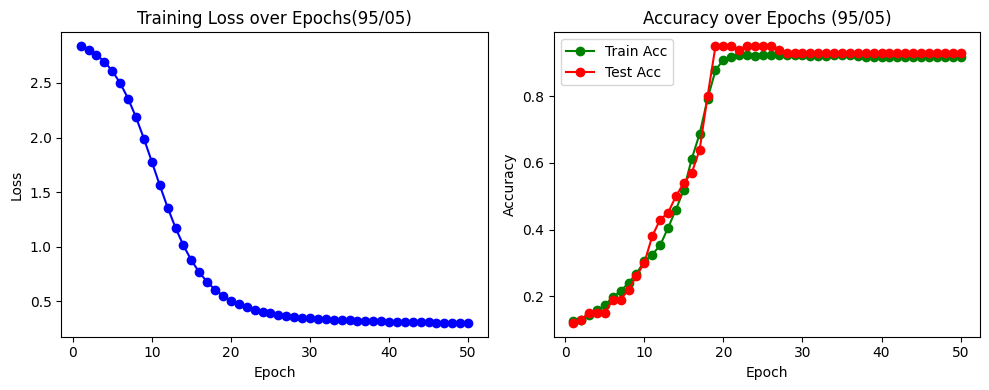

In [ ]:
plt.figure(figsize=(10,4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epoch_list, loss_list, marker='o', color='blue')
plt.title("Training Loss over Epochs(95/05)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epoch_list, train_acc_list, marker='o', label="Train Acc", color='green')
plt.plot(epoch_list, test_acc_list, marker='o', label="Test Acc", color='red')
plt.title("Accuracy over Epochs (95/05)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns

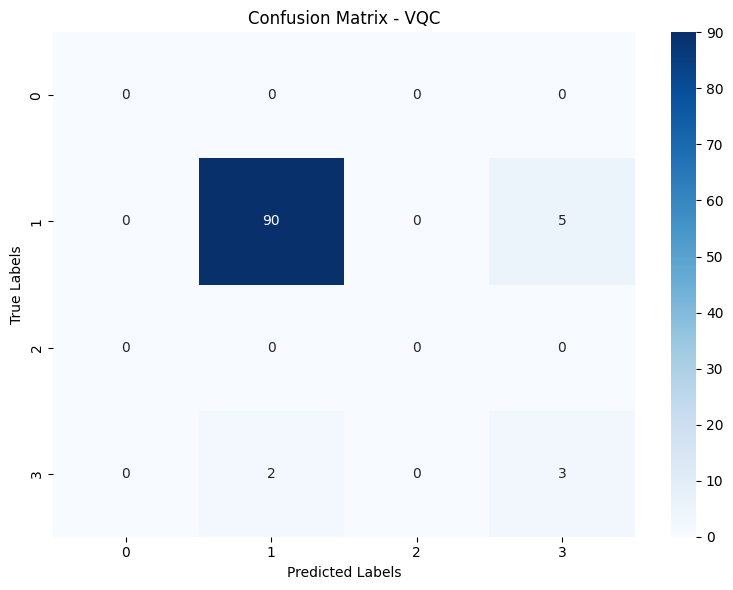

In [ ]:
# Ensure prediction and ground truth are in {0, 1}
predictions = np.array([quantum_model(params, x) for x in X_test])
probs = 0.5 * (predictions + 1)
y_pred = (probs > 0.5).astype(int)
y_true = ((y_test + 1) // 2).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - VQC")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()
